In [36]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array
from hera_filters import dspec
%matplotlib notebook

from jax import numpy as jnp
import jax
from hera_cal import redcal, datacontainer, apply_cal, abscal
from copy import deepcopy
jax.config.update("jax_enable_x64", True)
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

In [3]:
nfreqs = 200
nants = 30
npix = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.75
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=5)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

top = np.argsort(sky[0])[2:]

fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)
V_sky_inc = np.sum(sky[None, :, top] * beam[top].T[None] * fringe[..., top], axis=-1)

autos = np.sum(sky[None, :, top] * beam[top].T[None], axis=-1)

In [4]:
ant_amp = np.random.uniform(0.99, 1.01, (len(antpos), nfreqs))
ant_phase = np.random.uniform(0.99 * np.pi, 1.01 * np.pi, (len(antpos), nfreqs))


In [5]:
vis_dict = {}
model_dict = {}
true_dict = {}
ci = 0
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            g1 = ant_amp[ai] * np.exp(1j * ant_phase[ai])
            g2 = ant_amp[aj] * np.exp(1j * ant_phase[aj])
            vis_dict[(ai, aj)] = np.copy(V_sky[ci] * g1 * g2.conj())
            vis_dict[(aj, ai)] = np.copy(vis_dict[(ai, aj)].conj())
            model_dict[(ai, aj)] = V_sky_inc[ci]
            true_dict[(ai, aj)] = V_sky[ci]
            true_dict[(aj, ai)] = true_dict[(ai, aj)].conj()
            model_dict[(aj, ai)] = model_dict[(ai, aj)].conj()
            ci += 1
            
        if ai == aj:
            vis_dict[(ai, aj)] = autos[0]
            
            


In [134]:
def compute_indices(antpos):
    """
    """
    reds = redcal.get_pos_reds(antpos)
    
    idx1, idx2 = [], []
    p_idx = []
    red_sum_idx = [0]
    gcounter = 0
    
    for gi, group in enumerate(reds):
        for bl in group:
            idx1.append(bl[0])
            idx2.append(bl[1])
            p_idx.append(gi)
            
        gcounter += len(group)
        red_sum_idx.append(gcounter)
        
    idx1 = np.array(idx1)
    idx2 = np.array(idx2)
    p_idx = np.array(p_idx)
    
    idx_sort = np.argsort(p_idx)
    
    return idx1[idx_sort], idx2[idx_sort], p_idx[idx_sort], np.array(red_sum_idx)[:-1]

def redundant_stefcal(data_matrix, idx1, idx2, p_idx, red_sum_idx, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    model_matrix = np.zeros_like(data_matrix, dtype=complex)
    model_matrix[idx1, idx2] = 1
    model_matrix[idx2, idx1] = 1
    
    gains = np.ones((nants), dtype=complex)
    conv_crit = 1
    niter = 0
    
    y = np.ones(red_sum_idx.shape, dtype=complex)
    
    y = model_matrix[idx1, idx2]
    f = np.ones(y.shape,dtype=int)

    y = np.add.reduceat(y,red_sum_idx)
    f = np.add.reduceat(f,red_sum_idx)
    y = y/f
    
    while niter < maxiter:
        g_old = np.copy(gains)
        y_old = np.copy(y)
        
        # Update g
        z = gains[None] * model_matrix.T
        zw = np.conj(gains[None]) * model_matrix
        N = np.sum(z * data_matrix, axis=1)
        D = np.sum(z * zw, axis=1)
        
        val_den_idx = (np.abs(D) > 1e-6)
        
        gains[val_den_idx] = N[val_den_idx] / D[val_den_idx]
        gains[~val_den_idx] = 0
        
        gains = gains * stepsize + g_old * (1 - stepsize)
        
        # Update y
        num = np.conj(g_old[idx1]) * g_old[idx2] * data_matrix[idx1, idx2]
        den = np.abs(g_old[idx1]) ** 2 * np.abs(g_old[idx2]) ** 2
        num = np.add.reduceat(num, red_sum_idx)
        den = np.add.reduceat(den, red_sum_idx)
        
        val_den_idx = (np.abs(den) > 1e-6)
        
        y[val_den_idx] = num[val_den_idx] / den[val_den_idx]
        y[~val_den_idx] = 0
        y = stepsize * y + (1 - stepsize) * y_old
        
        model_matrix[idx1, idx2] = y[p_idx]
        model_matrix[idx2, idx1] = np.conj(y[p_idx])
        
        conv_crit = np.sqrt(np.square(np.abs(gains - g_old)).sum()) / np.sqrt(np.square(np.abs(gains)).sum())
        if conv_crit < tol:
            break
                
        niter += 1
    
         
    return gains, niter

@jax.jit
def stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    def inner_function(args):
        """
        """
        g_temp, i, tau = args
        g_old = jnp.copy(g_temp)
        zg = g_temp[:, None] * model_matrix
        zgw = g_temp[:, None] * model_matrix * wgts
        g_temp = jnp.sum(jnp.conj(data_matrix) * zgw, axis=(0)) / jnp.sum(jnp.conj(zgw) * zg, axis=(0))
        g_temp = g_temp * stepsize + g_old * (1 - stepsize)
        tau = jnp.sqrt(jnp.sum(jnp.abs(g_temp - g_old) ** 2))/ jnp.sqrt(jnp.sum(jnp.abs(g_temp)**2))
        return g_temp, i + 1, tau
    
    def conditional_function(args):
        """
        """
        _, i, tau = args
        return (tau > tol) & (i < maxiter)
    
    nants = data_matrix.shape[0]
    gains = jnp.ones(nants, dtype=complex)
    
    return jax.lax.while_loop(conditional_function, inner_function, (gains, 0, 1))

def run_stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    gains = []
    niter = []
    for i in range(data_matrix.shape[-1]):
        g, i, tau = stefcal(data_matrix[..., i], model_matrix[..., i], wgts[..., i], tol=tol, maxiter=maxiter, stepsize=stepsize)
        gains.append(g)
        niter.append(i)
        
    return np.array(gains).T, np.array(niter).T

In [135]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            data_matrix[m, n] = vis_dict[(m, n)]
            model_matrix[m, n] = model_dict[(m, n)]
            true_model_matrix[m, n] = true_dict[(m, n)]
            
wgts = np.ones_like(model_matrix).real
reds = redcal.get_reds(antpos)

data = {}
for k in vis_dict:
    data[k + ('nn',)] = vis_dict[k][None, :]

data = datacontainer.DataContainer(data)
data.freqs = freqs
data.times_by_bl = {k[:2]: np.array([1]) for k in data}

CPU times: user 16 ms, sys: 2.57 ms, total: 18.5 ms
Wall time: 17.1 ms


In [161]:
redcal.redundantly_calibrate??

In [162]:
%%time
meta, sol = redcal.redundantly_calibrate(data, reds, run_logcal=True, compute_chisq=False)

CPU times: user 822 ms, sys: 77.7 ms, total: 900 ms
Wall time: 700 ms


In [163]:
dmc = deepcopy(data)
apply_cal.calibrate_in_place(dmc, meta['fc_gains'])

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            data_matrix[m, n] = dmc[(m, n, 'nn')]
            model_matrix[m, n] = model_dict[(m, n)]
            true_model_matrix[m, n] = true_dict[(m, n)]

In [164]:
%%time
idx1, idx2, p_idx, red_sum_idx = compute_indices(antpos)

gains = []
niters = []
for fi in range(nfreqs):
    g, n = redundant_stefcal(data_matrix[:, :, fi], idx1, idx2, p_idx, red_sum_idx, stepsize=0.4)
    gains.append(g)
    niters.append(n)
    
gains = np.array(gains).T
niters = np.array(niters)
Gr = gains[:, None, :] * gains[None, ...].conj()
cal = data_matrix / Gr

g_dict = {(i, "Jnn"): gains[i][None, :] for i in range(gains.shape[0])}


gf = redcal.remove_degen_gains(reds, g_dict, meta['fc_gains'], mode='complex')
dc = deepcopy(data)
apply_cal.calibrate_in_place(dc, gf)

CPU times: user 1.79 s, sys: 12.7 ms, total: 1.8 s
Wall time: 1.8 s


<IPython.core.display.Javascript object>


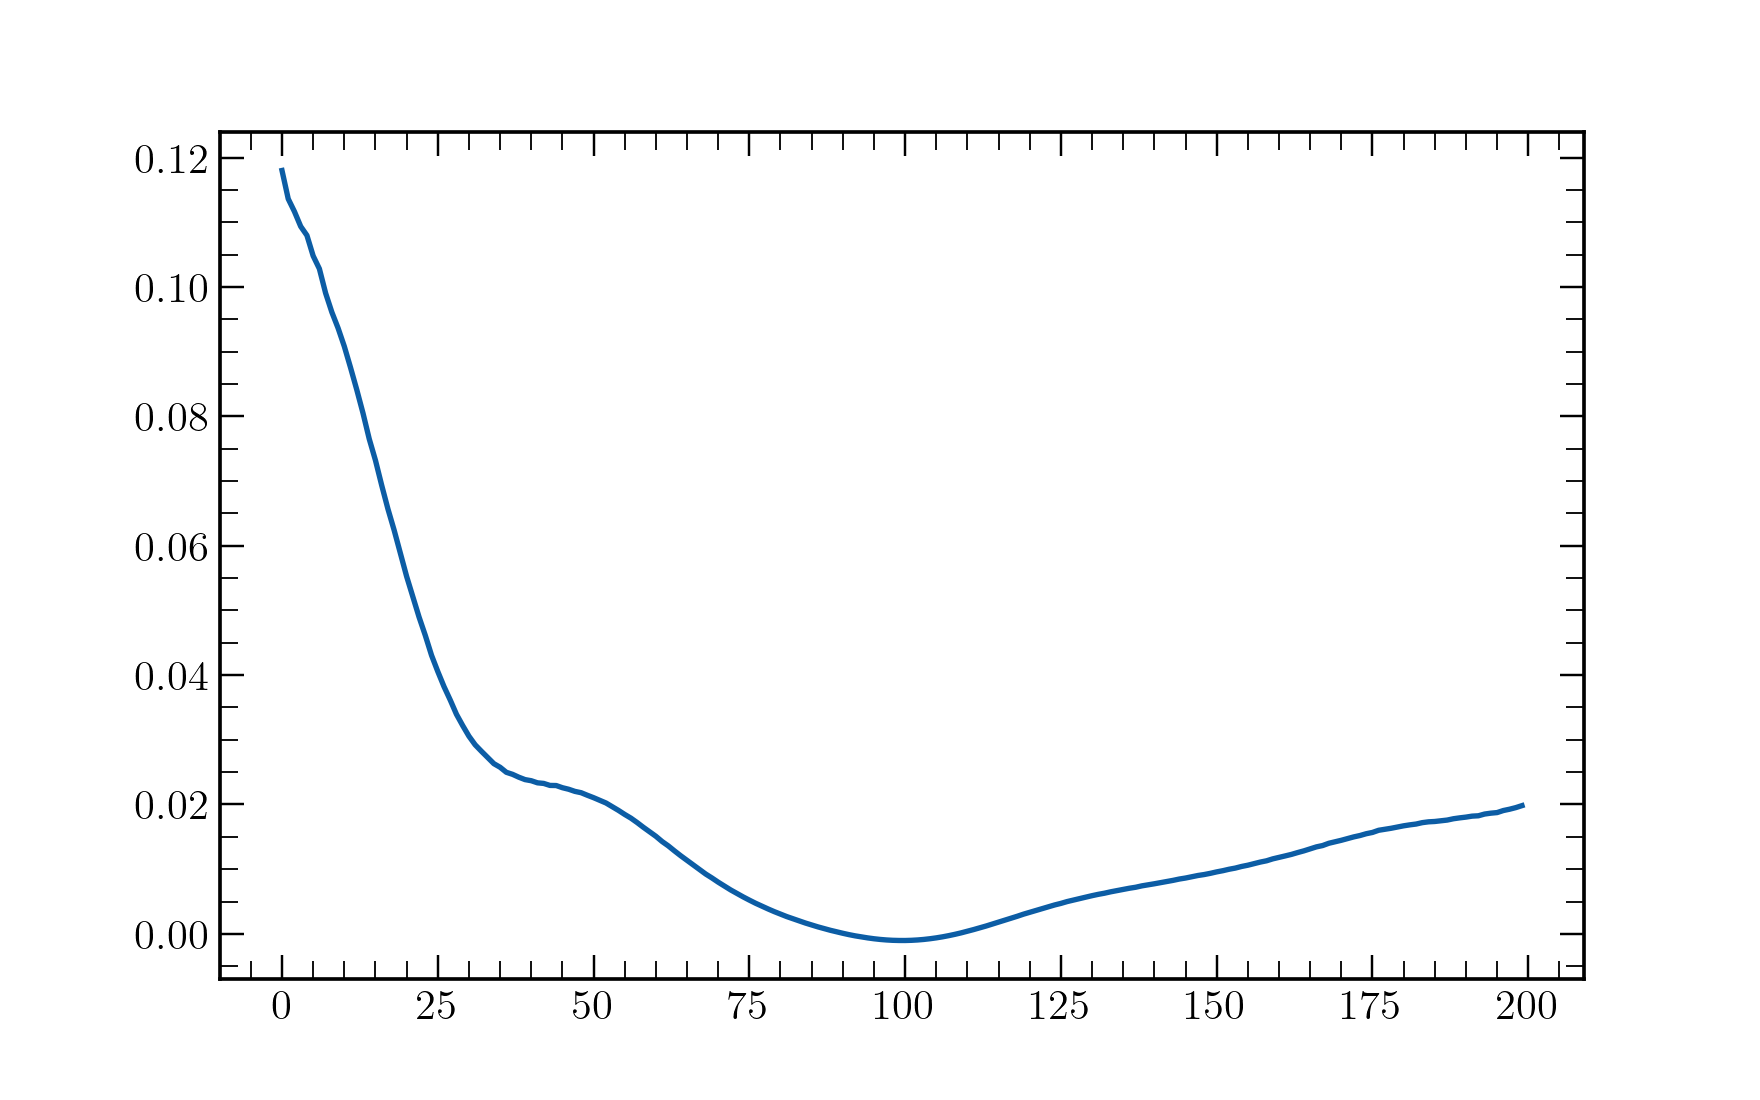

In [165]:
plt.figure()
plt.plot(dc[(0, 1, 'nn')][0].real - sol[(0, 1, 'nn')][0].real)
plt.show()

## Absolute Calibration

In [169]:
gain_ants = [(i, "Jnn") for i in range(nants)]
model_bls = [k for k in sol.vis]
data_bls = deepcopy(model_bls)

In [170]:
model = datacontainer.DataContainer({k + ('nn',): true_dict[k][None, :] for k in true_dict})

In [171]:
%%time
sol_copy = deepcopy(sol)

amp_gains = abscal.abs_amp_logcal(model, sol, return_gains=True, gain_ants=gain_ants, verbose=False)
meta, phs_gains = abscal.complex_phase_abscal(sol, model, reds, model_bls, data_bls)
degen_gains = {k: amp_gains[k] * phs_gains[k] for k in amp_gains}
sol_copy.remove_degen(degen_gains)

amp_gains = abscal.abs_amp_logcal(model, dc, return_gains=True, gain_ants=gain_ants, verbose=False)
meta, phs_gains = abscal.complex_phase_abscal(dc, model, reds, model_bls, data_bls)
degen_gains = {k: amp_gains[k] * phs_gains[k] for k in amp_gains}

full_gains = redcal.remove_degen_gains(reds, g_dict, degen_gains, mode='complex')
rdc = deepcopy(data)
apply_cal.calibrate_in_place(rdc, full_gains)

CPU times: user 202 ms, sys: 6.91 ms, total: 209 ms
Wall time: 206 ms


<IPython.core.display.Javascript object>


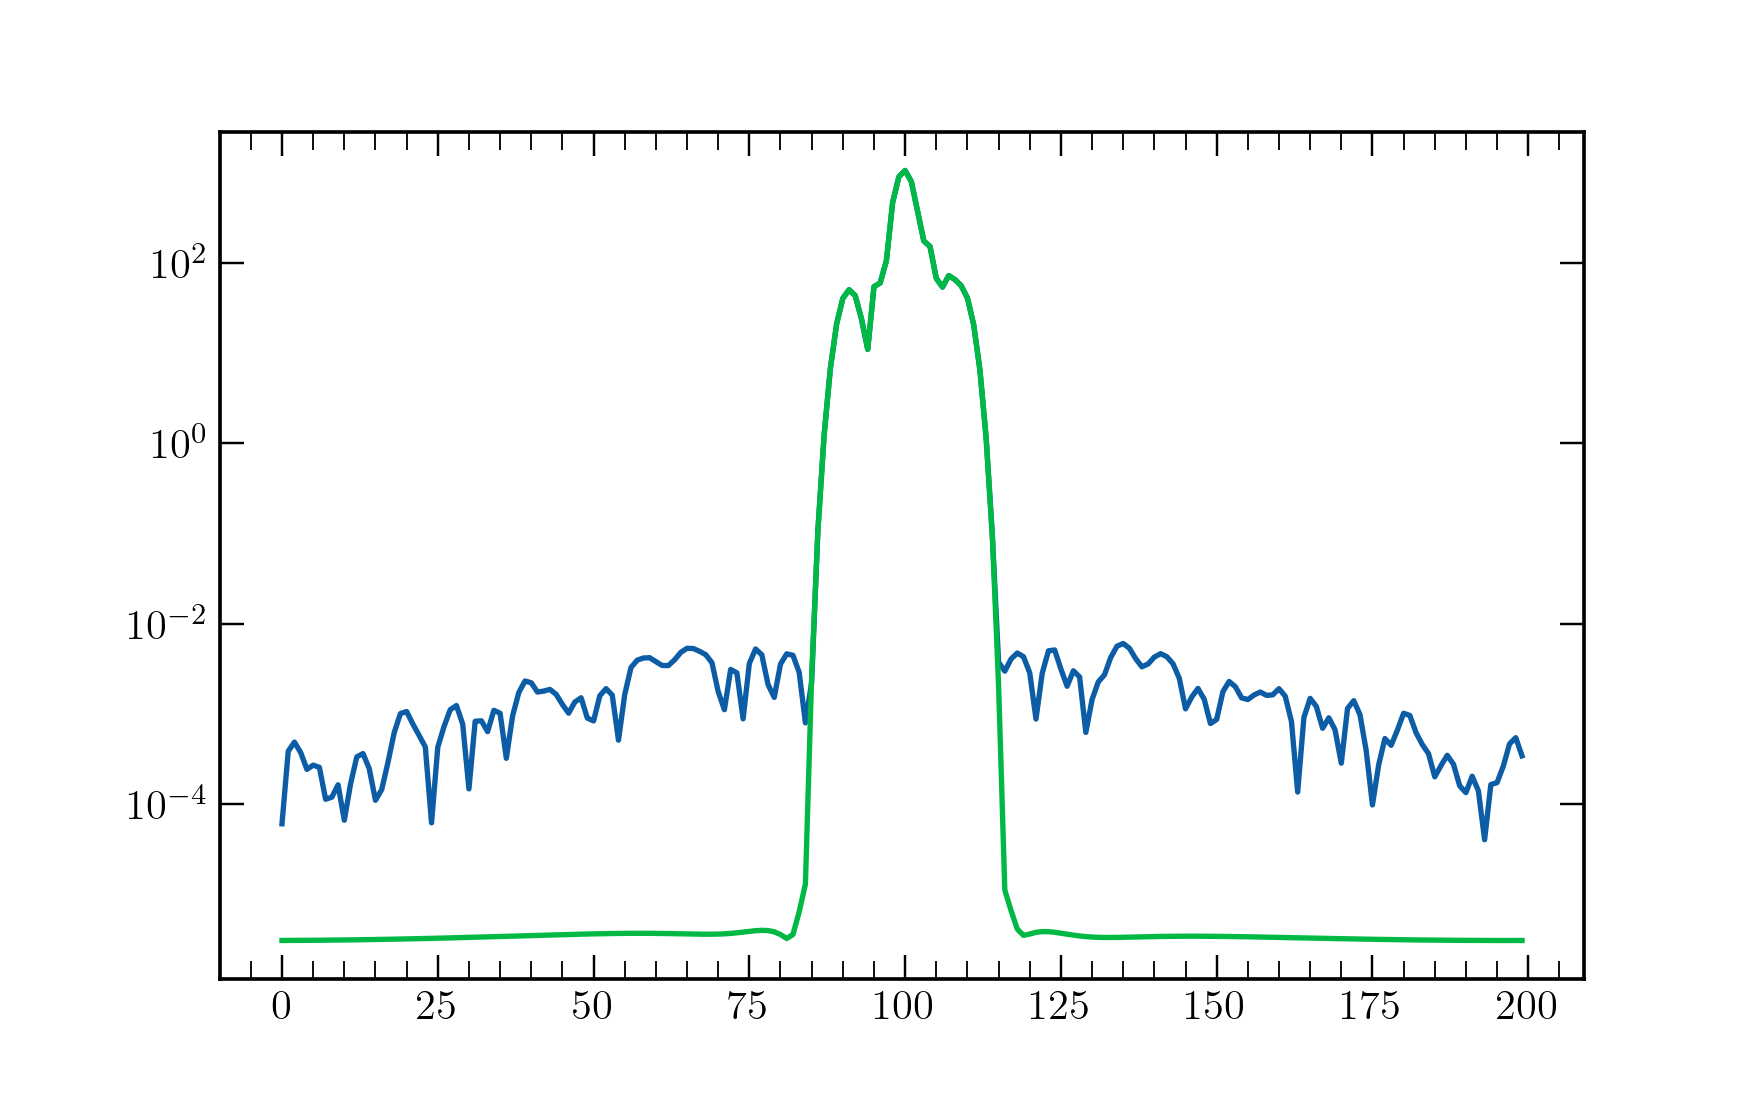

In [172]:
plt.figure()
plt.semilogy(delay_spectra(rdc[(0, 2, 'nn')][0]))
plt.semilogy(delay_spectra(sol_copy[(0, 2, 'nn')][0]))